In [1]:
import itertools
import functools

import torch

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torchvision import datasets, transforms
import torchvision.transforms as transforms

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

import random

import copy
import math
import pickle
import argparse

from torch.optim.lr_scheduler import StepLR
import torchvision
import imageio.v2 as imageio

from mup_nets import ReLUResNetMUP_manual
from train_utils import get_random_data_unif_binary, train_mse, test_mse, ERMDatasetFromFuncBinary
from decision_tree_utils import DecisionTree, AndOfLiterals, comp_and_list, \
                                tup_to_literals, literals_to_tup
from probing_utils import batch_linear_probe_adam
from tqdm import tqdm

import time

In [2]:
def load_net(save_model_name):
    net = torch.load(save_model_name + '.pt')
    return net


def load_tree_and_net(dtreefile,netfile=None,loss_type='mse'):
    # Load network and decision tree
    dtree = pickle.load(open(f'dectrees/{dtreefile}.pkl', 'rb'))
    if netfile is None:
        save_model_name = 'saved_models/' + dtreefile + f'_{loss_type}'
        net = load_net(save_model_name)
    else:
        net = load_net(netfile)
    return dtree, net

In [3]:
def get_activs(model,x):
    memorized_activs = {}
    with torch.no_grad():
        y = model.forward(x, return_activations=memorized_activs)
        memorized_activs[('output')] = torch.sign(y)
    return memorized_activs

def get_norm_concat_activs(model,x):
    activ = get_activs(model,x)
    # activ_list = [activ[k] / torch.norm(activ[k]) for k in activ.keys()]
    activ_list = [activ[k] for k in activ.keys()]
    newactiv = torch.cat(activ_list,dim=1)
    newactiv = newactiv / torch.norm(newactiv)
    newactiv = newactiv * math.sqrt(newactiv.shape[0])
    return newactiv

## Decision tree distillation

In [4]:
device = torch.device("cuda")

In [5]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [6]:

def get_best_tree_dyn_prog(x, outfn, tup_list, s_list=None,verbose=False):

    if s_list is None:
        s = len(tup_list)
        s_list = [s]
    else:
        s = max(s_list)

    # Get loss value from having an AND as a leaf
    if verbose:
        print('Starting AND computation')
        starttime = time.time()

    # Compute and for list of tuples
    tupmat = torch.tensor(tup_list, dtype=torch.float).to(device)
    nnz = torch.count_nonzero(tupmat,dim=1).view(1,-1)
    muls = x @ tupmat.T
    tupcomp = (muls > nnz - 0.5) * 1

    # tupcomp = (comp_and_list(x, [tup_to_literals(tup) for tup in tup_list])+1)/2
    if verbose:
        endtime = time.time()
        print('Done with AND computation', endtime - starttime)
        print('Assigning values to tuples')
        starttime = time.time()

    tup_coverage = torch.sum(tupcomp,dim=0)
    tup_vals = tup_coverage / (2 * outfn.shape[0]) + (1/2) * torch.abs(torch.sum(outfn * tupcomp,dim=0)) / outfn.shape[0]
    tup_sgn = torch.sign(torch.sum(outfn * tupcomp,dim=0)) # Best sign if it is a leaf
    if verbose:
        endtime = time.time()
        print('Done assigning values to tuples', endtime - starttime)
        print('Constructing tree of ANDs')
        starttime = time.time()

    # Construct tree 
    tup_to_idx = {}
    for idx, tup in enumerate(tup_list):
        tup_to_idx[tup] = idx
    d = len(tup_list[0])

    # Slow -- currently main bottleneck
    tup_to_children_pairs = {}
    for tup in tqdm(tup_list):
        tup_to_children_pairs[tup] = []
        for i in range(d):
            if tup[i] == 0:
                # Are successors in the list?
                l = list(tup)
                l[i] = 1
                tup1 = tuple(l)
                l[i] = -1
                tupm1 = tuple(l)
                if tup1 in tup_to_idx.keys() and tupm1 in tup_to_idx.keys():
                    tup_to_children_pairs[tup].append((tup1,tupm1))

    # Relatively fast conversion to indices
    idx_to_children_pairs = {}
    for tup in tqdm(tup_to_children_pairs):
        ci = tup_to_idx[tup]
        idx_to_children_pairs[ci] = [(tup_to_idx[t1], tup_to_idx[t2]) for (t1,t2) in tup_to_children_pairs[tup]]


    if verbose:
        endtime = time.time()
        print('Tree of ANDs constructed', endtime - starttime)
        print('Setting up dynamic program')
        starttime = time.time()

    idx_depth_r = {}
    rs = set()
    for tup in tqdm(tup_list):
        tupr = sum([tup[i] != 0 for i in range(d)])
        if tupr not in idx_depth_r:
            idx_depth_r[tupr] = []
        idx_depth_r[tupr].append(tup_to_idx[tup])
        rs.add(tupr)

    ## Construct list of edges -- relatively efficient
    rs = list(rs)
    rs.sort()
    edge_r_par = {}
    edge_r_c1 = {}
    edge_r_c2 = {}

    for r in tqdm(rs):
        edge_r_par[r] = flatten([[pidx]*len(idx_to_children_pairs[pidx]) for pidx in idx_depth_r[r]])
        edge_r_c1[r] = flatten([[a[0] for a in idx_to_children_pairs[pidx]] for pidx in idx_depth_r[r]])
        edge_r_c2[r] = flatten([[a[1] for a in idx_to_children_pairs[pidx]] for pidx in idx_depth_r[r]])
        # print(edge_r_par[r])

    rs.sort()
    rs.reverse()
    mem_vals = tup_vals.repeat(s,1) # size x num_tuples
    mem_inds = torch.zeros(mem_vals.shape,dtype=torch.long).to(device)-1
    for r in tqdm(rs):
        if len(edge_r_c1[r]) > 0: # If there are edges to earlier layers,
            num_edges = len(edge_r_c1[r])
            e1 = mem_vals[:,edge_r_c1[r]]
            e2 = mem_vals[:,edge_r_c2[r]]
            # Compute the min-plus
            e1 = e1.view(e1.shape[0],1,-1)
            e2 = e2.view(1,e2.shape[0],-1)
            edge_sum = e1 + e2
            edge_sum = edge_sum.view(-1,num_edges)

            idxsquare = torch.arange(0,s).view(-1,1) + torch.arange(0,s).view(1,-1)
            idxsquare = idxsquare.view(-1)

            etot = torch.zeros((s,num_edges)).to(device)
            einds = torch.zeros((s,num_edges),dtype=torch.long).to(device)
            for cs in range(0,s-2):
                idxsub = idxsquare == cs
                edgemax = torch.max(edge_sum[idxsub,:],dim=0)
                # esumcurrind = edgemax.indices
                # in general, can only start at cs+2 = 2 (which is size 3)
                # if cs+2 = 10, this is size 11, so want sums of 0,8 and 1,7 (which is 1,9), etc...
                # einds[cs+2,:] = edgemax.indices
                etot[cs+2,:] = edgemax.values

            # This is the main bottleneck, and not worth it to optimize right now,
            # since overall program is at least 20x faster than previously
            for idx, p in enumerate(edge_r_par[r]):
                upd_edge = etot[:,idx] > mem_vals[:,p]
                mem_vals[:,p] = torch.maximum(mem_vals[:,p], etot[:,idx])
                mem_inds[upd_edge,p] = idx

    if verbose:
        endtime = time.time()
        print('Time for dynamic program', endtime - starttime)
        print('Converting to DecisionTree format')
        starttime = time.time()

    out_trees = {}
    for true_size in s_list:
        s = true_size - 1

        # Convert to DecisionTree format
        root_idx = idx_depth_r[0][0]
        and_list = []
        child_dict = {}
        idx_to_size = {}
        and_len = []

        and_list.append(root_idx)
        and_len.append(0)
        idx_to_size[root_idx] = s
        sgn_dict = {}
        i = 0
        while i < len(and_list):
            ct = and_list[i]
            r = and_len[i]
            cs = idx_to_size[ct]
            if mem_inds[cs,ct] >= 0: # i.e., not -1, which indicates no child
                curredge = mem_inds[cs,ct]
                l_idx = edge_r_c1[r][curredge]
                r_idx = edge_r_c2[r][curredge]

                # Compute sl, sr
                l_vals = mem_vals[:,l_idx]
                r_vals = mem_vals[:,r_idx]
                mval = 0
                mind = -1
                for sl in range(0,cs-1):
                    sr = cs - sl - 2
                    cval = l_vals[sl] + r_vals[sr]
                    if cval > mval:
                        mval = cval
                        mind = sl
                sl = mind
                sr = cs - sl - 2
                assert(mval == mem_vals[cs,ct])
                idx_to_size[l_idx] = sl
                idx_to_size[r_idx] = sr
                and_list.append(l_idx)
                and_len.append(r+1)
                and_list.append(r_idx)
                and_len.append(r+1)
                child_dict[tup_list[ct]] = (tup_list[l_idx],tup_list[r_idx])
            else:
                sgn_dict[tup_list[ct]] = round(tup_sgn[ct].item())
                child_dict[tup_list[ct]] = None
            i += 1


        newtree = DecisionTree(root_tup=tup_list[root_idx], child_dict = child_dict, sgn_dict = sgn_dict)
        out_trees[true_size] = (newtree, mem_vals[s,root_idx])

    if verbose:
        endtime = time.time()
        print('Converted to DecisionTree format', endtime-starttime)

    return out_trees

## Distillation procedure

In [7]:
def get_successor_tups(tup):
    new_tups = []
    for i in range(len(tup)):
        if tup[i] != 0:
            continue
        for j in [1,-1]:
            tup1 = copy.deepcopy(list(tup))
            tup1[i] = j
            tup1 = tuple(tup1)
            new_tups.append(tup1)
    return new_tups

def search_net_for_tree_ands(dtree, net, top_k=500,max_depth=5, num_concurrent_probes=20000,
                      num_samples=1000,val_num_samples=10000,
                            probe_iters=1001,probe_iter_log=-1,probe_eta=0.01):
    
    x = get_random_data_unif_binary(d=d,num_samples=num_samples).to(device)
    valx = get_random_data_unif_binary(d=d,num_samples=val_num_samples).to(device)
    activs = get_norm_concat_activs(net,x)
    valactivs = get_norm_concat_activs(net,valx)

    ## Only branch out on top-k tuples at each depth, so only at most 2*k*d tuples ever probed per layer

    tups_to_probe = {}
    probe_vals = {}
    start_tup = tuple([0]*d)
    tups_to_probe[0] = [start_tup]

    for r in range(max_depth+1):
        print('Current depth ',r)

        currlits = [tup_to_literals(qa) for qa in tups_to_probe[r]]
        probe_vals[r] = []

        i = 0
        while i < len(currlits):
            num_to_test = min(num_concurrent_probes,len(currlits)-i)
            litsub = currlits[i:i+num_to_test]
            fns = comp_and_list(x, litsub)
            valfns = comp_and_list(valx, litsub)
            print('Testing # of tups:', fns.shape[1])
            train_errs, errs = batch_linear_probe_adam(activs, fns, valrep=valactivs,valfns=valfns,
                                                  eta=probe_eta,num_iters=probe_iters, norm_bound=math.inf, iter_log = probe_iter_log)
            probe_vals[r].extend(errs.tolist())
            i += num_to_test
        if r == max_depth:
            break

        errs = torch.tensor(probe_vals[r])
        top_idx = torch.topk(errs,min(top_k,len(errs)),largest=False).indices
        top_tups = [tups_to_probe[r][idx] for idx in top_idx]
        # print(top_tups)
        newtups = set()
        for qa in tqdm(top_tups):
            new_tups = get_successor_tups(qa)
            newtups.update(new_tups)

        tups_to_probe[r+1] = list(newtups)
        print(len(tups_to_probe[r+1]))
        
        
    return tups_to_probe, probe_vals

def extract_tup_list_from_probe_output(tups_to_probe, probe_vals,verbose=True):
    tup_list = []
    ks = list(tups_to_probe.keys())
    ks.sort()
    for r in ks:
        if verbose:
            print('-'*50)
            print(len(tups_to_probe[r]))
        curr_l = [(probe_vals[r][idx], tups_to_probe[r][idx]) for idx in range(len(tups_to_probe[r]))]
        curr_l.sort()
        for i in range(min(1000,len(curr_l))):
            p = curr_l[i]
            if verbose:
                print(p[0],i, tup_to_literals(p[1]))
        tup_list.extend(curr_l)
    return tup_list

In [8]:
models_to_distill = []

with open('testaccs.csv', 'r') as f:
    trained_trees_and_models = f.readlines()
    header = trained_trees_and_models[0]
    trained_trees_and_models = trained_trees_and_models[1:]

for l in trained_trees_and_models:
    # print(l)
    a = l.replace('\n','').split(',')
    save_model_name = a[0]
    dtreename = a[1]
    modelloss = float(a[2])
    modelacc = a[3]
    # print(trained_trees_and_models)
    # print(save_model_name,dtreename,modelloss,modelacc)
    
    if modelloss < 1e-3 and 'class' in save_model_name and 'dectrees_100_' in save_model_name:
        print(modelacc)
        # dtree, net = load_tree_and_net(dtreename,save_model_name)
        # dot = dtree.visualize(zero_ones=True)
        models_to_distill.append((dtreename,save_model_name))

100.0
100.0
100.0
100.0
100.0


dectrees_100_2


100%|██████████| 3/3 [00:00<00:00, 2277.86it/s]


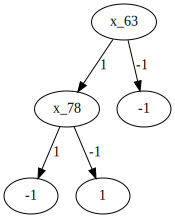

dectrees_100_2 10
saved_reconstructions/dectrees_100_2_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top10_0.pkl
num probed ands 2141
dectrees_100_2 50
saved_reconstructions/dectrees_100_2_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top50_0.pkl
num probed ands 8901
dectrees_100_2 100
saved_reconstructions/dectrees_100_2_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top100_0.pkl
num probed ands 15101
dectrees_100_2 200
saved_reconstructions/dectrees_100_2_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top200_0.pkl
num probed ands 20001


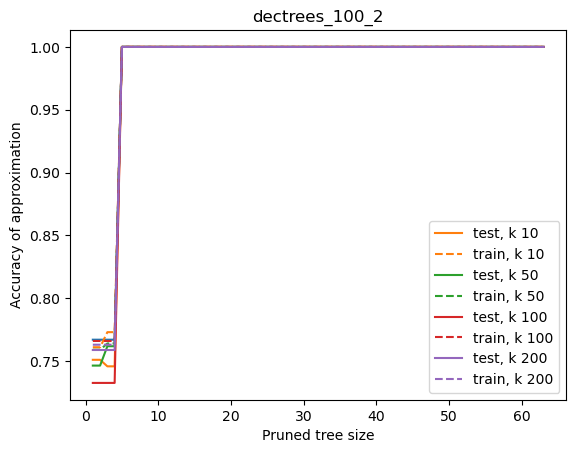

dectrees_100_3


100%|██████████| 4/4 [00:00<00:00, 1142.32it/s]


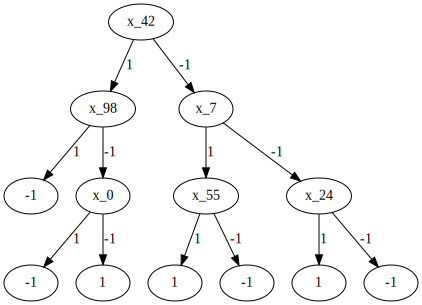

dectrees_100_3 10
saved_reconstructions/dectrees_100_3_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top10_0.pkl
num probed ands 4091
dectrees_100_3 50
saved_reconstructions/dectrees_100_3_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top50_0.pkl
num probed ands 18459
dectrees_100_3 100
saved_reconstructions/dectrees_100_3_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top100_0.pkl
num probed ands 33122
dectrees_100_3 200
saved_reconstructions/dectrees_100_3_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top200_0.pkl
num probed ands 48213


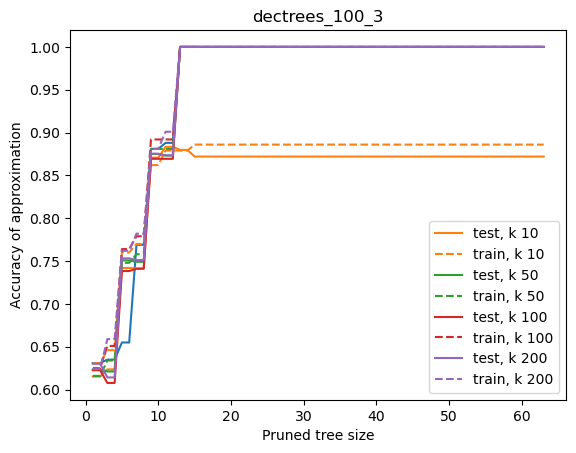

dectrees_100_4


100%|██████████| 5/5 [00:00<00:00, 589.22it/s]


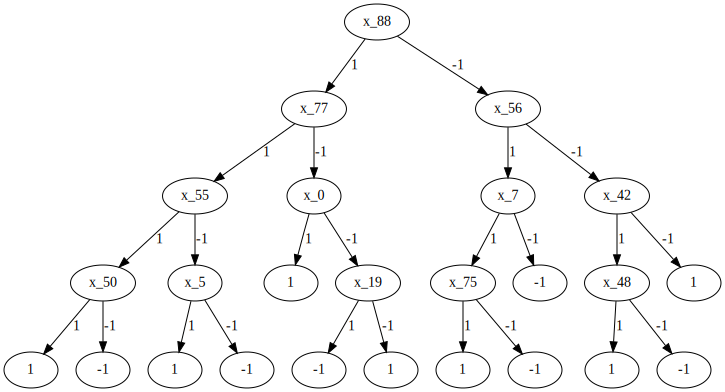

dectrees_100_4 10
saved_reconstructions/dectrees_100_4_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top10_0.pkl
num probed ands 6022
dectrees_100_4 50
saved_reconstructions/dectrees_100_4_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top50_0.pkl
num probed ands 28042
dectrees_100_4 100
saved_reconstructions/dectrees_100_4_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top100_0.pkl
num probed ands 52856
dectrees_100_4 200
saved_reconstructions/dectrees_100_4_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top200_0.pkl
num probed ands 94227


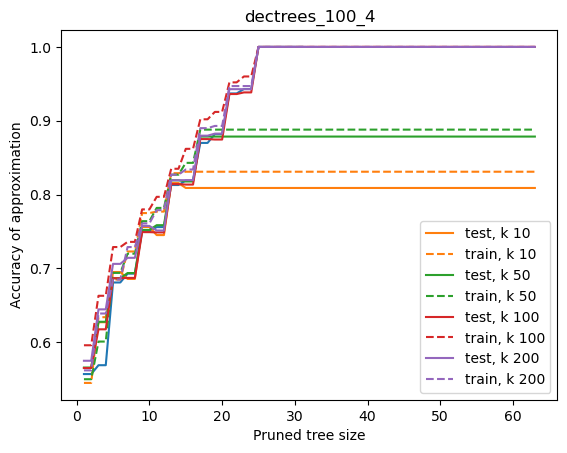

dectrees_100_5


100%|██████████| 6/6 [00:00<00:00, 267.45it/s]


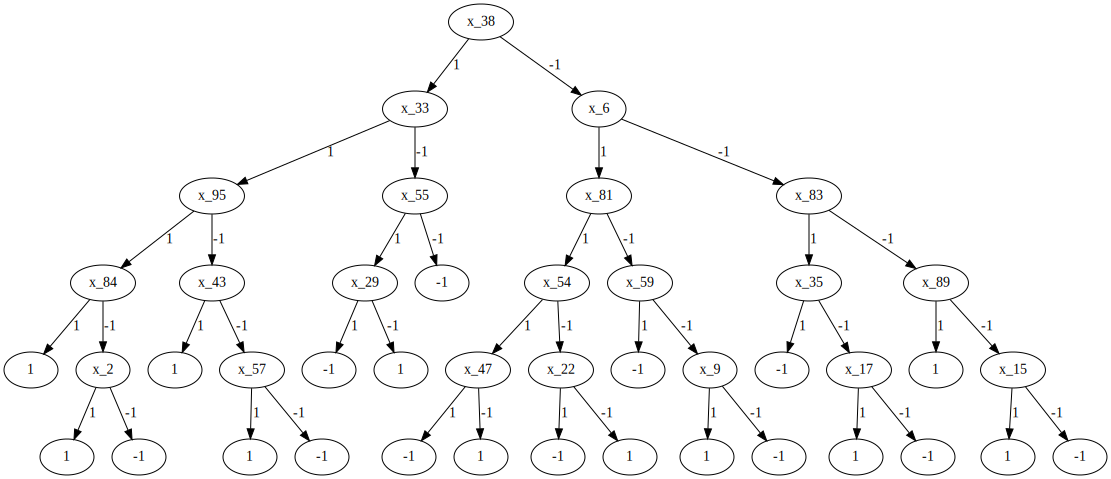

dectrees_100_5 10
saved_reconstructions/dectrees_100_5_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top10_0.pkl
num probed ands 7925
dectrees_100_5 50
saved_reconstructions/dectrees_100_5_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top50_0.pkl
num probed ands 37569
dectrees_100_5 100
saved_reconstructions/dectrees_100_5_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top100_0.pkl
num probed ands 71850
dectrees_100_5 200
saved_reconstructions/dectrees_100_5_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top200_0.pkl
num probed ands 131976
dectrees_100_5 500
saved_reconstructions/dectrees_100_5_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top500_0.pkl
num probed ands 291339
dectrees_100_5 1000
saved_reconstructions/dectrees_100_5_class_erm100000_sgd0.05_epochs10_reconstructed_tree_top1000_0.pkl
num probed ands 540090


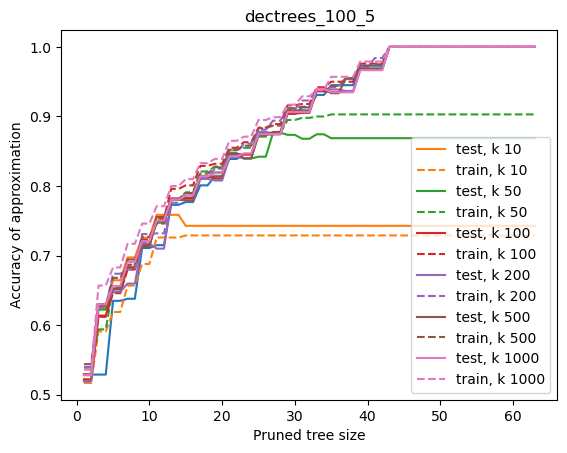

dectrees_100_5


100%|██████████| 6/6 [00:00<00:00, 264.63it/s]


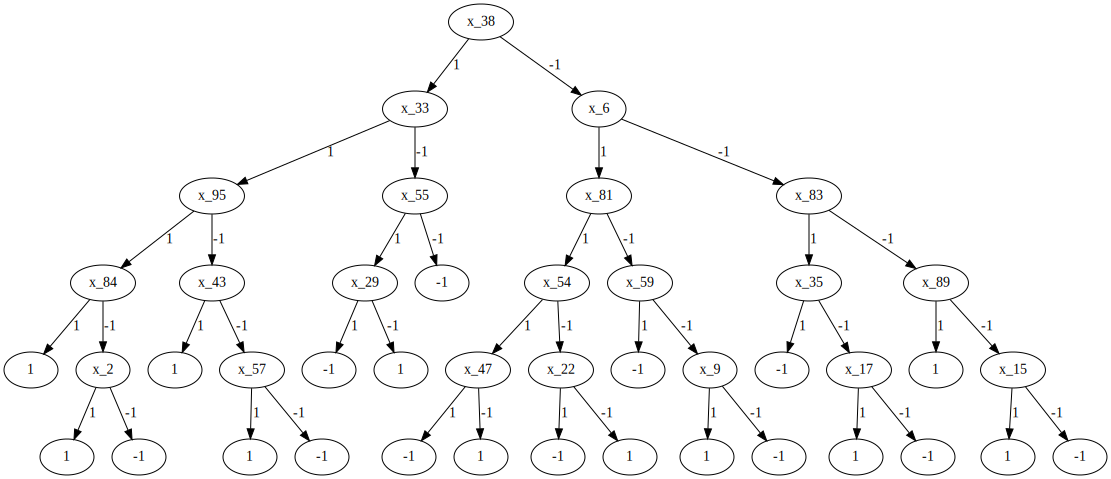

dectrees_100_5 10
saved_reconstructions/dectrees_100_5_class_erm1000000_sgd0.05_epochs10_reconstructed_tree_top10_0.pkl
num probed ands 7936
dectrees_100_5 50
saved_reconstructions/dectrees_100_5_class_erm1000000_sgd0.05_epochs10_reconstructed_tree_top50_0.pkl
num probed ands 37563
dectrees_100_5 100
saved_reconstructions/dectrees_100_5_class_erm1000000_sgd0.05_epochs10_reconstructed_tree_top100_0.pkl
num probed ands 71717
dectrees_100_5 200
saved_reconstructions/dectrees_100_5_class_erm1000000_sgd0.05_epochs10_reconstructed_tree_top200_0.pkl
num probed ands 131455
dectrees_100_5 500
saved_reconstructions/dectrees_100_5_class_erm1000000_sgd0.05_epochs10_reconstructed_tree_top500_0.pkl
num probed ands 283887
dectrees_100_5 1000
saved_reconstructions/dectrees_100_5_class_erm1000000_sgd0.05_epochs10_reconstructed_tree_top1000_0.pkl
num probed ands 527532


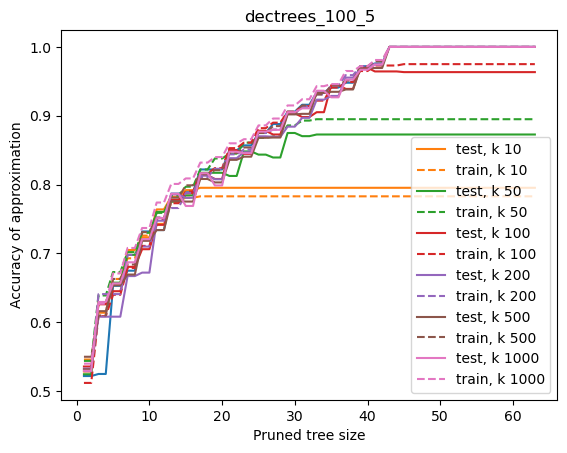

In [17]:

    
for dtreename, save_model_name in models_to_distill:
    
    top_ks = [10,50,100,200]
    if 'dectrees_100_5' in dtreename:
        top_ks = [10,50,100,200,500,1000]
        # continue
    
    print(dtreename)
    dtree, net = load_tree_and_net(dtreename,save_model_name)
    
    d = len(dtree.ands[0].get_tup())
    x = get_random_data_unif_binary(d=d,num_samples=1000).to(device)
    tup_list = [a.get_tup() for a in dtree.ands]
    outfn = dtree.compute(x).view(-1,1)
    num_tups = len(tup_list)
    size_range =range(1,num_tups+1)
    # size_range = [1]
    out_trees = get_best_tree_dyn_prog(x, outfn, tup_list,s_list=size_range)
    # out_trees[1][0].visualize()
    plt.plot(size_range, [out_trees[k][1].item() for k in size_range])
    plt.xlabel('Pruned tree size')
    plt.ylabel('Accuracy of approximation')
    plt.title('Accuracy of best subtree vs. size')
    min_s = min([k for k in out_trees.keys() if out_trees[k][1] > 0.999])
    prunedtree = out_trees[min_s][0]
    pruneddot = prunedtree.visualize()
    
    r = max([len(x.get_literals()[0]) for x in dtree.ands]) # depth of tree
    
    for top_k in top_ks: 
        print(dtreename,top_k)
        d = net.linears[0].in_features
        
        short_model_name = save_model_name.replace('saved_models/', '')

        probed_and_file = f'saved_reconstructions/{short_model_name}_probed_ands_top{top_k}_0.pkl'
        rec_file = f'saved_reconstructions/{short_model_name}_reconstructed_tree_top{top_k}_0.pkl'

        print(rec_file)

        if os.path.exists(probed_and_file):
            probed_ands = pickle.load(open(probed_and_file, 'rb'))
        else:
            tups_to_probe, probe_vals = search_net_for_tree_ands(dtree, net, top_k=top_k,max_depth=r,
                                                             num_concurrent_probes=20000,
                                                             num_samples=1000,val_num_samples=10000,
                                                                probe_iters=101, probe_eta=0.05)
            probed_ands = extract_tup_list_from_probe_output(tups_to_probe, probe_vals, verbose=False)

            pickle.dump(probed_ands, open(probed_and_file, 'wb'))

        print('num probed ands', len(probed_ands))

        check_cover=False
        if check_cover:
            print('Do these probed ands cover the tree?')
            true_tups = [a.get_tup() for a in dtree.ands]
            for tup in true_tups:
                found = False
                for v in probed_ands:
                    if v[1] == tup:
                        print(v[0],tup_to_literals(tup))
                        found = True
                        break
                if not found:
                    print('NOT FOUND', tup_to_literals(tup))


                valx = get_random_data_unif_binary(d=d,num_samples=5000)
        if os.path.exists(rec_file):
            rectrees = pickle.load(open(rec_file, 'rb'))
        else:
            tup_list = [qa[1] for qa in probed_ands]
            x = get_random_data_unif_binary(d=d,num_samples=1000).to(device)
            outfn = dtree.compute(x).view(-1,1)
            rectrees = get_best_tree_dyn_prog(x, outfn, tup_list,s_list=range(1,64),verbose=True)
            # reconstructedtree.visualize()
            pickle.dump(rectrees, open(rec_file, 'wb'))

        show_out = False
        # if show_out:
        valx = get_random_data_unif_binary(d=d,num_samples=5000).to(device)
        outfn = dtree.compute(valx).view(-1,1)
        sizes = rectrees.keys()
        train_accs = []
        test_accs = []
        for s in rectrees.keys():
            reconstructedtree = rectrees[s][0]
            reconstructed = reconstructedtree.compute(valx).view(-1,1)
            test_acc = torch.sum((torch.sign(outfn * reconstructed)+1)/2) / outfn.shape[0]
            train_acc = rectrees[s][1]
            train_accs.append(train_acc.item())
            test_accs.append(test_acc.item())
            if show_out:
                print(f'size {s}\ttrain {train_acc:.3f}\ttest {test_acc:.3f}')
        ax = plt.gca()
        color=next(ax._get_lines.prop_cycler)['color']
        plt.plot(sizes, test_accs, label=f'test, k {top_k}', color=color)
        plt.plot(sizes, train_accs, '--', label=f'train, k {top_k}', color=color)
    plt.title(dtreename)
    plt.legend()
    plt.show()

        # Is there a way to batch these computations?
        # It seems that we can construct a list of possible edges, create a matrix that is of dimensions EDGE x TREE SIZE, and 


In [18]:
results = []
    
for dtreename, save_model_name in models_to_distill:
    
    print(dtreename)
    print(save_model_name)
    dtree, net = load_tree_and_net(dtreename,save_model_name)
    
    d = len(dtree.ands[0].get_tup())
    r = max([len(x.get_literals()[0]) for x in dtree.ands]) # depth of tree

    top_ks = [10,50,100,200]
    if 'dectrees_100_5' in dtreename:
        top_ks = [10,50,100,200,500,1000]
        
        
    for top_k in top_ks:   
        short_model_name = save_model_name.replace('saved_models/', '')
        probed_and_file = f'saved_reconstructions/{short_model_name}_probed_ands_top{top_k}_0.pkl'
        rec_file = f'saved_reconstructions/{short_model_name}_reconstructed_tree_top{top_k}_0.pkl'

        probed_ands = pickle.load(open(probed_and_file, 'rb'))
        num_probed_ands = len(probed_ands)
        print('num probed ands', num_probed_ands)
        rectrees = pickle.load(open(rec_file, 'rb'))

        valx = get_random_data_unif_binary(d=d,num_samples=5000).to(device)
        outfn = dtree.compute(valx).view(-1,1)
        sizes = rectrees.keys()
        train_accs = []
        test_accs = []
        s = max(rectrees.keys())
        # for s in rectrees.keys():
        reconstructedtree = rectrees[s][0]
        reconstructed = reconstructedtree.compute(valx).view(-1,1)
        test_acc = torch.sum((torch.sign(outfn * reconstructed)+1)/2) / outfn.shape[0]
        train_acc = rectrees[s][1]
        train_accs.append(train_acc.item())
        test_accs.append(test_acc.item())
        
        results.append((dtreename, save_model_name, top_k, train_acc, test_acc))
        
        print(f'size {s}\ttrain {train_acc:.3f}\ttest {test_acc:.3f}')

dectrees_100_2
saved_models/dectrees_100_2_class_erm100000_sgd0.05_epochs10
num probed ands 2141
size 63	train 1.000	test 1.000
num probed ands 8901
size 63	train 1.000	test 1.000
num probed ands 15101
size 63	train 1.000	test 1.000
num probed ands 20001
size 63	train 1.000	test 1.000
dectrees_100_3
saved_models/dectrees_100_3_class_erm100000_sgd0.05_epochs10
num probed ands 4091
size 63	train 0.886	test 0.873
num probed ands 18459
size 63	train 1.000	test 1.000
num probed ands 33122
size 63	train 1.000	test 1.000
num probed ands 48213
size 63	train 1.000	test 1.000
dectrees_100_4
saved_models/dectrees_100_4_class_erm100000_sgd0.05_epochs10
num probed ands 6022
size 63	train 0.831	test 0.814
num probed ands 28042
size 63	train 0.888	test 0.874
num probed ands 52856
size 63	train 1.000	test 1.000
num probed ands 94227
size 63	train 1.000	test 1.000
dectrees_100_5
saved_models/dectrees_100_5_class_erm100000_sgd0.05_epochs10
num probed ands 7925
size 63	train 0.729	test 0.728
num probed a

In [20]:
pickle.dump(results, open('results.pkl', 'wb'))

In [21]:
results = pickle.load(open('results.pkl', 'rb'))

In [22]:
treenames = list(set([x[0] for x in models_to_distill]))

In [23]:
results_dict = {}
for dtreename in treenames:
    results_dict[dtreename] = [x for x in results if x[0] == dtreename]

In [24]:
import scipy.stats

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022b/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [26]:
res_by_r_k = {}

for r in [2,3,4,5]:
    print(r)
    for suffix in ['']: #,'_a','_b','_c','_d'
        dtn = f'dectrees_100_{r}{suffix}'
        a = results_dict[dtn]
        
        num_samples = 100000
        if r == 5:
            num_samples = 1000000
        a = [x for x in a if f'erm{num_samples}_' in x[1]]
        topk = [x[2] for x in a]
        
        for k in topk:
            if (r,k) not in res_by_r_k.keys():
                res_by_r_k[(r,k)] = []
            aa = [x for x in a if x[2] == k]
            assert(len(aa) == 1)
            aa = aa[0]
            short_model_name = aa[1].replace('saved_models/', '')
            probed_and_file = f'saved_reconstructions/{short_model_name}_probed_ands_top{k}_0.pkl'
            
            probed_ands = pickle.load(open(probed_and_file, 'rb'))
            num_probed_ands = len(probed_ands)
            res_by_r_k[(r,k)].append((aa, num_probed_ands))

2
3
4
5


In [27]:
print('\\begin{tabular}{ccccc}')
print('depth & $k$ & \\begin{tabular}{c} fraction of inputs \\\\ distillation is correct \\end{tabular} & \\begin{tabular}{c} average \\\\ number of probes \\end{tabular} & fraction of possible probes\\\\ ')
for r in [2,3,4,5]:
    print('\\hline')
    topk = [10, 50, 100, 200]
    if r == 5:
        topk = [10, 50, 100, 200, 500, 1000]
    for k in topk:
        accs = [x[0][4].item() for x in res_by_r_k[(r,k)]]
        accs = [f'{a:0.2f}' for a in accs]
        num_probes = [x[1] for x in res_by_r_k[(r,k)]]
        probe_avg = np.mean(num_probes)
        probe_std = scipy.stats.sem(num_probes)
        possible_probes = 0
        for i in range(r+1):
            possible_probes += (2**i) * math.comb(100,i)
        frac_probes = probe_avg / possible_probes
        if k == topk[-1]:
            line = '\\textbf{' + f'{r}' + '} & \\textbf{' + f'  {k}' + '}' + f' & ' + '\\textbf{' + '\\{' + ', '.join(accs) + '\\} '  + '}' + ' & \\textbf{' + f'{probe_avg:0.0f}' + '} & \\textbf{ ' + f'{frac_probes:0.4f}' + '} \\\\ '
        else:
            line = f'{r} & {k} & ' + '$\\{ ' + ','.join(accs) + ' \\}$ & ' + f'${probe_avg:0.0f}$ & ${frac_probes:0.4f}$' + ' \\\\ '
        print(line)
print('\\end{tabular}')
        # print(res_by_r_k[(r,k)])

\begin{tabular}{ccccc}
depth & $k$ & \begin{tabular}{c} fraction of inputs \\ distillation is correct \end{tabular} & \begin{tabular}{c} average \\ number of probes \end{tabular} & fraction of possible probes\\ 
\hline
2 & 10 & $\{ 1.00 \}$ & $2141$ & $0.1070$ \\ 
2 & 50 & $\{ 1.00 \}$ & $8901$ & $0.4450$ \\ 
2 & 100 & $\{ 1.00 \}$ & $15101$ & $0.7550$ \\ 
\textbf{2} & \textbf{  200} & \textbf{\{1.00\} } & \textbf{20001} & \textbf{ 1.0000} \\ 
\hline
3 & 10 & $\{ 0.87 \}$ & $4091$ & $0.0031$ \\ 
3 & 50 & $\{ 1.00 \}$ & $18459$ & $0.0141$ \\ 
3 & 100 & $\{ 1.00 \}$ & $33122$ & $0.0252$ \\ 
\textbf{3} & \textbf{  200} & \textbf{\{1.00\} } & \textbf{48213} & \textbf{ 0.0367} \\ 
\hline
4 & 10 & $\{ 0.81 \}$ & $6022$ & $0.0001$ \\ 
4 & 50 & $\{ 0.87 \}$ & $28042$ & $0.0004$ \\ 
4 & 100 & $\{ 1.00 \}$ & $52856$ & $0.0008$ \\ 
\textbf{4} & \textbf{  200} & \textbf{\{1.00\} } & \textbf{94227} & \textbf{ 0.0015} \\ 
\hline
5 & 10 & $\{ 0.79 \}$ & $7936$ & $0.0000$ \\ 
5 & 50 & $\{ 0.88 \}$ & $

/home/gridsan/eboix/.local/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gridsan/eboix/.local/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
